<a href="https://colab.research.google.com/github/bereml/iap/blob/master/libretas/2a_fashion_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de MNIST con un red convolucional

Curso: [Introducción al Aprendizaje Profundo](http://turing.iimas.unam.mx/~ricardoml/course/iap/). Profesores: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/) Montalvo Lezama.

---
---

En esta libreta veremos un ejemplo de clasificación multiclase de imágenes implementando una red convolucional en PyTorch.

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) es un conjunto para remplzar MNIST. Fue recolectado con la intención de proveer un conjunto un poco más dificil que MNIST.

<img src="https://miro.medium.com/max/1776/1*-kpgaee9X9Gm-SrQKdk_og.png" width="800"/>
Conjunto Fashion-MNIST. Imagen tomada de https://towardsdatascience.com/multi-label-classification-and-class-activation-map-on-fashion-mnist-1454f09f5925?gi=73df5adfbbf4.

## 1 Preparación

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

### 1.1 Bibliotecas

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
# procesamiento de imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm.auto import trange

### 1.2 Auxiliares

In [3]:
# directorio de datos
DATA_DIR = '../datos'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8

# Fashion-MNIST classes
CLASSES = {
    0: "T-shirt/top", 
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal",
    6: "Shirt", 
    7: "Sneaker",
    8: "Bag", 
    9: "Ankle boot",
}


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:3])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

## 2 Datos

### 2.1 Tuberias de datos con PyTorch

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/mnist_pipeline.png"/>

### 2.2 Cargadores de datos

#### Entrenamiento

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


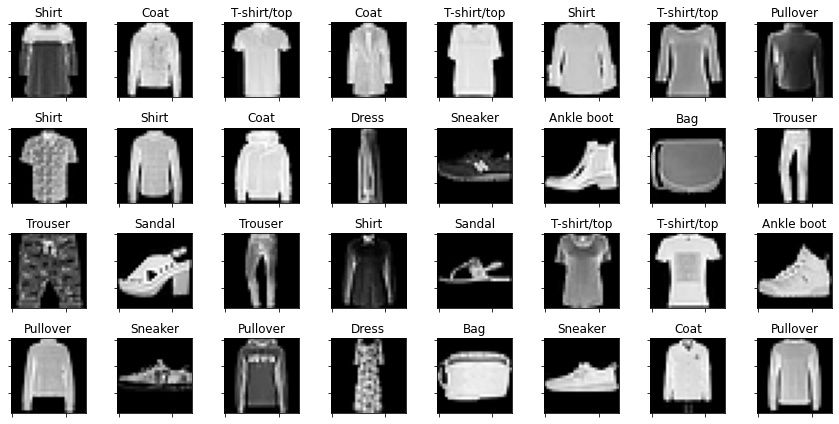

In [4]:
# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm,
    # descaraga
    download=True
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [CLASSES[l] for l in y.tolist()]
display_batch(x, titles, ROWS, COLS)

#### Prueba

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


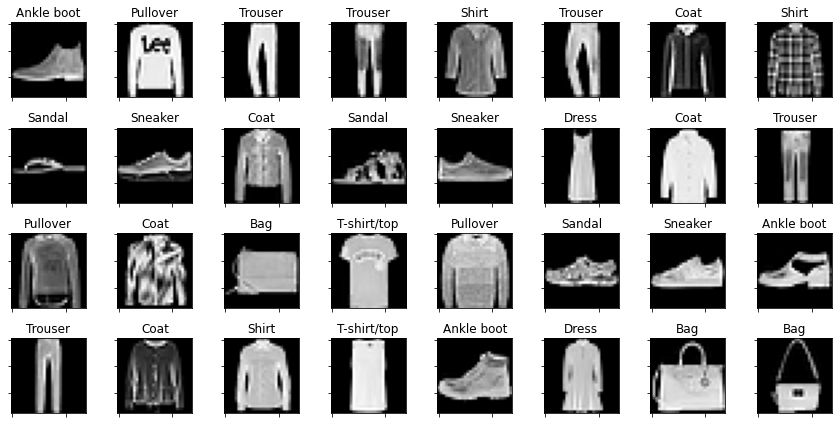

In [5]:
# creamos un Dataset
tst_ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=False
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [CLASSES[l] for l in y.tolist()]
display_batch(x, titles, ROWS, COLS)

## 3 Modelo

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/mnist_cnn1.svg" width="300"/>

### 3.1 Definición de la arquitectura

In [6]:
# definición del arquitectura
class CNN(nn.Module):
    
    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        self.num_feats = 4 * 14 * 14

        # definición de bloques conv
        # [M, 1, 28, 28] => [M, 4, 14, 14]
        self.cnn = nn.Sequential(

            # bloque conv1
            # [M, 1, 28, 28] => [M, 4, 28, 28]
            nn.Conv2d(in_channels=1, out_channels=4, 
                      kernel_size=3, padding=1),
            # [M, 4, 28, 28]
            nn.ReLU(),
            # [M, 4, 28, 28] => [M, 4, 14, 14]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )       
        
        # [M, 4, 14, 14] => [M, 4x14x14]
        self.flatten = nn.Flatten()

        # [M, 4x14x14] => [M, 1]
        self.cls = nn.Linear(self.num_feats, 10)
    
    # metodo para inferencia
    def forward(self, x):
        # [M, 1, 28, 28] => [M, 4, 14, 14]
        x = self.cnn(x)
        # [M, 4, 14, 14] => [M, 4x14x14]
        x = self.flatten(x)
        # [M, 4x14x14] => [M, 10]
        x = self.cls(x)
        return x

### 3.2 Instancia de la arquitectura

In [7]:
model = CNN()
print(model)

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=784, out_features=10, bias=True)
)


In [8]:
# inferencia con datos sintéticos
x = torch.zeros(1, 1, 28, 28)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 1, 28, 28]) => torch.Size([1, 10])


### 3.3 Inspección de la arquitectura

In [9]:
summary(model, (1, 1, 28, 28), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 4, 14, 14]            --
|    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
|    └─ReLU: 2-2                         [1, 4, 28, 28]            --
|    └─MaxPool2d: 2-3                    [1, 4, 14, 14]            --
├─Flatten: 1-2                           [1, 784]                  --
├─Linear: 1-3                            [1, 10]                   7,850
Total params: 7,890
Trainable params: 7,890
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.03
Estimated Total Size (MB): 0.06

## 4 Entrenamiento

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/supervisado.svg" width="700"/>
&nbsp;
Ciclo de entrenamiento supervisado.

### 4.1 Ciclo de entrenamiento

In [10]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

Entrenamos un modelo:

In [11]:
# instanciamos un modelo
model = CNN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[126.31,126.87] acc=[68.20,67.56]
E01 loss=[ 76.13, 77.32] acc=[74.37,73.46]
E02 loss=[ 65.66, 67.26] acc=[76.77,76.18]
E03 loss=[ 60.32, 62.21] acc=[78.90,78.03]
E04 loss=[ 56.61, 58.72] acc=[80.12,79.28]
E05 loss=[ 54.20, 56.42] acc=[80.98,79.95]
E06 loss=[ 52.45, 54.97] acc=[81.71,80.46]
E07 loss=[ 51.21, 53.54] acc=[82.16,80.93]
E08 loss=[ 49.54, 52.24] acc=[82.86,81.52]
E09 loss=[ 48.50, 51.20] acc=[83.04,81.90]
E10 loss=[ 47.49, 50.21] acc=[83.57,82.21]
E11 loss=[ 47.36, 49.93] acc=[83.37,82.30]
E12 loss=[ 46.21, 49.00] acc=[84.14,82.65]
E13 loss=[ 45.87, 48.68] acc=[84.04,82.74]
E14 loss=[ 45.38, 48.14] acc=[84.24,82.84]
E15 loss=[ 45.20, 48.00] acc=[84.30,82.97]
E16 loss=[ 44.27, 47.16] acc=[84.80,83.24]
E17 loss=[ 44.02, 46.94] acc=[84.75,83.25]
E18 loss=[ 43.93, 46.71] acc=[84.77,83.57]
E19 loss=[ 43.34, 46.26] acc=[85.09,83.93]


### 4.2 Gráficas de pérdidas y exactitud

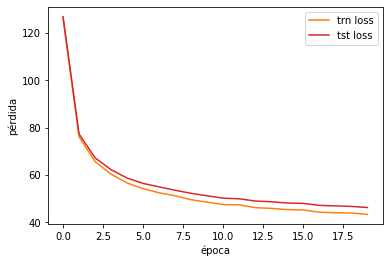

In [12]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

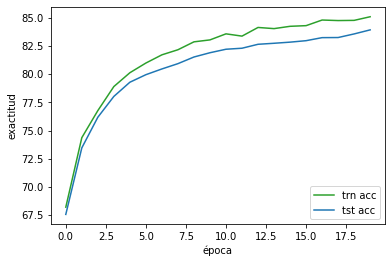

In [13]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

## 5 Evaluación

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/eval_trn_tst.svg" width="450"/>
&nbsp;
Entrenamiento con una partición de entrenamiento y prueba.

### 5.1 Evaluación final

In [14]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 43.34, 46.26] acc=[85.09,83.93]


### 5.2 Inferencia

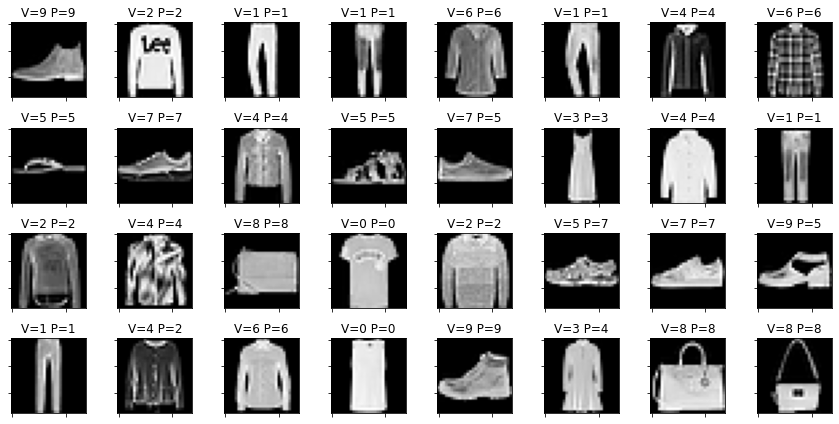

In [15]:
with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)

## 6. Mini caso de estudio

Emplearemos este ejemplo para estudiar el comportamiento de las redes conforme agregamos más capas. Para esto realizaremos las siguientes etapas e iremos registrando los resultados en la tabla al final.

1. Agregar otro bloque Conv como se indica en la libreta `2a_fashion_cnn_eje.ipynb`.

2. ¿Qué podemos observar? ¿Qué pasaría si entrenamos más epocas?

3. Remplaza el optimizador `optim.SGD` con `optim.Adam` y vuelve a entrenar 20 épocas ambos modelos.

4. ¿Qué pasa con los desempeños?

5. Encapsula las capas del bloque Conv en un módulo reutilizable y remplaza en la arquitectura.  Agrega otro bloque con 64 filtros y vuelve a entrenar.

6. ¿Qué comportamiento se observa entre las curvas en entrenamiento y prueba en el modelo con 3 bloques?

Resultados:


| Bloques | Épocas | Optimizador | Exactitud |
| ------- | ------ | ----------- | --------- |
| 1       | 20     | SGD         | 83.93     |
| 2       | 20     | SGD         | 81.98     |
| 1       | 50     | SGD         | 85.71     |
| 2       | 50     | SGD         | 85.79     |
| 1       | 20     | Adam        | 88.87     |
| 2       | 20     | Adam        | 89.53     |
| 3       | 20     | Adam        | 90.53     |
